In [20]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


Задание 1 (0.5 балла) Подготовка

Разделите выборку на train, val, test (80%, 10%, 10%)

Выдерите salary_in_usd в качестве таргета

Найдите и удалите признак, из-за которого возможен лик в данных

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
df.drop('salary', axis=1, inplace=True) #исключаем признак, из-за которого возможен лик в данных

train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.125, random_state=42)

X_train = train.drop(columns=["salary_in_usd"])
y_train = train["salary_in_usd"]

X_val = val.drop(columns=["salary_in_usd"])
y_val = val["salary_in_usd"]

X_test = test.drop(columns=["salary_in_usd"])
y_test = test["salary_in_usd"]

Задание 2 (0.5 балла) Линейная модель

Закодируйте категориальные признаки с помощью OneHotEncoder

Обучите модель линейной регрессии

Оцените качество через MAPE и RMSE

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

df_new = pd.get_dummies(df, drop_first=True)
data_new = df_new.astype(int)

train, test = train_test_split(data_new, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.125, random_state=42)

X_train_e = train.drop(columns=["salary_in_usd"])
y_train = train["salary_in_usd"]

X_val_e = val.drop(columns=["salary_in_usd"])
y_val = val["salary_in_usd"]

X_test_e = test.drop(columns=["salary_in_usd"])
y_test = test["salary_in_usd"]

model = LinearRegression()
model.fit(X_train_e, y_train)

predictions = model.predict(X_test_e)

mape = mean_absolute_percentage_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')


MAPE: 45840005.592392825
RMSE: 14945662708557.248


Задание 3 (0.5 балла) XGboost

Обучите модель XGBRegressor на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (max_depth, learning_rate, n_estimators, gamma, etc.) по валидационной выборке.

Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказани

In [31]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import time

xgb = XGBRegressor()

params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb, param_grid=params, scoring='neg_mean_absolute_percentage_error', cv=3)
grid_search.fit(X_val_e, y_val)

best_params = grid_search.best_params_

best_xgb = XGBRegressor(**best_params)
start_time = time.time()
best_xgb.fit(X_val_e, y_val)
training_time = time.time() - start_time

start_time = time.time()
y_pred = best_xgb.predict(X_val_e)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print('Best params:', best_params)
print('MAPE:', mape)
print('RMSE:', rmse)
print('Training time:', training_time)
print('Prediction time:', prediction_time)

Best params: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
MAPE: 0.2925680748074468
RMSE: 42267.26634704362
Training time: 0.19243192672729492
Prediction time: 0.03054523468017578


MAPE и RMSE заметно снизились

Задание 4 (1 балл) CatBoost

Обучите модель CatBoostRegressor, подобрав оптимальные гиперпараметры (depth, learning_rate, iterations, etc.) по валидационной выборке.

Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [24]:
!pip install catboost
from catboost import CatBoostRegressor

In [25]:
from catboost import CatBoostRegressor

best_mape = float('inf')
best_model = None
best_params = None

start_time = time.time()

for depth in range(6, 10):
    for learning_rate in [0.05, 0.1, 0.2]:
        for iterations in [100, 200, 300]:
            params = {
                'depth': depth,
                'learning_rate': learning_rate,
                'iterations': iterations,
                'loss_function': 'MAPE',
                'eval_metric': 'MAPE',
                'verbose': False
            }

            model = CatBoostRegressor(**params)
            model.fit(X_train_e, y_train, eval_set=(X_val_e, y_val))

            mape = mean_absolute_percentage_error(y_val, model.predict(X_val_e))
            rmse = mean_squared_error(y_val, model.predict(X_val_e), squared=False)

            if mape < best_mape:
                best_mape = mape
                best_model = model
                best_params = params

end_time = time.time()

print('Best MAPE:', best_mape)
print('Best RMSE:', rmse)
print('Best parameters:', best_params)
print('Training time:', end_time - start_time)


start_time_pred = time.time()
predictions = best_model.predict(X_test_e)
end_time_pred = time.time()

print('Prediction time:', end_time_pred - start_time_pred)


Best MAPE: 0.4719021911747546
Best RMSE: 80928.04367093535
Best parameters: {'depth': 8, 'learning_rate': 0.2, 'iterations': 200, 'loss_function': 'MAPE', 'eval_metric': 'MAPE', 'verbose': False}
Training time: 42.03238916397095
Prediction time: 0.01669788360595703


MAPE и RMSE увеличились по сравнению с прошлой моделью

Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features.

In [30]:
from catboost import Pool

cat_features = list(df.select_dtypes(include=['object', 'category']).columns)
train_pool = Pool(data=X_train_e, label=y_train)
val_pool = Pool(data=X_val_e, label=y_val)

best_mape = float('inf')
best_model = None
best_params = None

start_time = time.time()

for depth in range(6, 10):
    for learning_rate in [0.05, 0.1, 0.2]:
        for iterations in [100, 200, 300]:
            params = {
                'depth': depth,
                'learning_rate': learning_rate,
                'iterations': iterations,
                'loss_function': 'MAPE',
                'eval_metric': 'MAPE',
                'verbose': False
            }

            model = CatBoostRegressor(**params)
            model.fit(train_pool, eval_set=val_pool)

            mape = mean_absolute_percentage_error(y_val, model.predict(X_val_e))
            rmse = mean_squared_error(y_val, model.predict(X_val_e), squared=False)

            if mape < best_mape:
                best_mape = mape
                best_model = model
                best_params = params

end_time = time.time()

print('Best MAPE:', best_mape)
print('Best RMSE:', rmse)
print('Best Parameters:', best_params)
print('Training time:', end_time - start_time)

# Оценка скорости предсказания
start_time_pred = time.time()
predictions = best_model.predict(X_test_e)
end_time_pred = time.time()

print('Prediction time:', end_time_pred - start_time_pred)

Best MAPE: 0.4719021911747546
Best RMSE: 80928.04367093535
Best Parameters: {'depth': 8, 'learning_rate': 0.2, 'iterations': 200, 'loss_function': 'MAPE', 'eval_metric': 'MAPE', 'verbose': False}
Training time: 24.83645749092102
Prediction time: 0.011590719223022461


Задание 5 (0.5 балла)
используйте LGBMRegressor, снова подберите гиперпараметры, оцените качество и скорость.

In [ ]:
from lightgbm import LGBMRegressor
import numpy as np



params = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 500],
    'num_leaves': [31, 127, 255],
    'subsample': [0.8, 0.9, 1.0]
}

start_time = time.time()

model = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_e, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_e)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Best Parameters:', grid_search.best_params_)
print('MAPE: ', mape)
print('RMSE: ', rmse)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 2628, number of used features: 38
[LightGBM] [Info] Start training from score 137603.785008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

Задание 6 (2 балла) Сравнение и выводы
Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

По результатам сравнения моделей бустинга можно сделать следующие выводы:

1) Качество моделей:

LGBMRegressor показал наилучшее качество: MAPE 0.0797 и RMSE 8706.75.
XGBoost продемонстрировал средние результаты с MAPE 0.293 и RMSE 42267
CatBoost уступил другим моделям с MAPE 0.4719 и RMSE 80928.04.

2) Скорость обучения:
XGBoost обучался  быстро(training time: 0.19), CatBoost дольше (training time: 42.03). LGBMRegressor требовал самого длительного обучения (Training time: 214.84 seconds).


3)Скорость предсказания:
XGBoost выполнял предсказание за prediction time: 0.031
CatBoost был наиболее быстрым в предсказании: 0.016 секунды без пула, 0.008 секунды с пулом данных.

CatBoost показал наилучшую скорость предсказания, опередив XGBoost примерно вдвое. Использование пула данных ещё больше ускорило работу CatBoost.

4)Гиперпараметры лучших моделей:
Каждая модель имеет свои оптимальные настройки гиперпараметров. Общими являются примерно глубина деревьев и скорость обучения. Число базовых алгоритмов и специфические параметры различаются между моделями.

Итак, XGBoost продемонстрировал наилучший баланс качества и скорости обучения, а CatBoost был самым быстрым в предсказании.

Часть 2 Кластеризация (5 баллов)

In [32]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [33]:
transposed_ratings = ratings.T
transposed_ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием user.

In [34]:
transposed_ratings = transposed_ratings.drop('user')

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)

Доля исполнителя в музыке, прослушанной пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.

In [36]:
ratings = transposed_ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
jeffterson airplane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014782,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [37]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 5,  random_state=0)
k_means = k_means.fit(ratings)
clusters = k_means.predict(ratings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [40]:
cluster_sizes = np.bincount(clusters)
cluster_sizes

array([996,   1,   1,   1,   1])

Кластеризация оказалась бесполезной: практически все наблюдения были отнесены к одному кластеру, в то время как остальные четыре кластера содержат лишь по одному наблюдению. Мы не можем придать смысловую обьясняющую каждому кластеру в таком случае.
Причиной такого результата может быть несколько факторов:
Метод k-средних имеет ограничения в выделении кластеров сложной формы из-за особенностей своего алгоритма. Он лучше работает с линейно разделимыми данными.
Метод чувствителен к выбросам, которые могут существенно влиять на центры кластеров и искажать результаты.
Необходимость заранее задавать количество кластеров с предварительным анализом оптимального значения этого параметра(метод локтя/силуэтов/gap-статистика).
Ещё наличие нулевых значений вместо пропусков может смещать средние значения признаков и влиять на качество кластеризации.

Задание 3 (0.5 балла) Объяснение результатов
При кластеризации получилось  кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [42]:
from collections import Counter
cluster_counts = Counter(clusters)

single_artist_clusters = [index for index, cluster in enumerate(clusters) if cluster_counts[cluster] == 1]

for artist_index in single_artist_clusters:
    artist_name = ratings.index[artist_index]
    print(artist_name)



the beatles
daft punk
morricone
보아


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

         Average number of listeners  Average listening
Cluster                                                
0                         132.335341           0.000972
1                         540.000000           0.004222
2                        1671.000000           0.018369
3                          48.000000           0.001462
4                          66.000000           0.001007


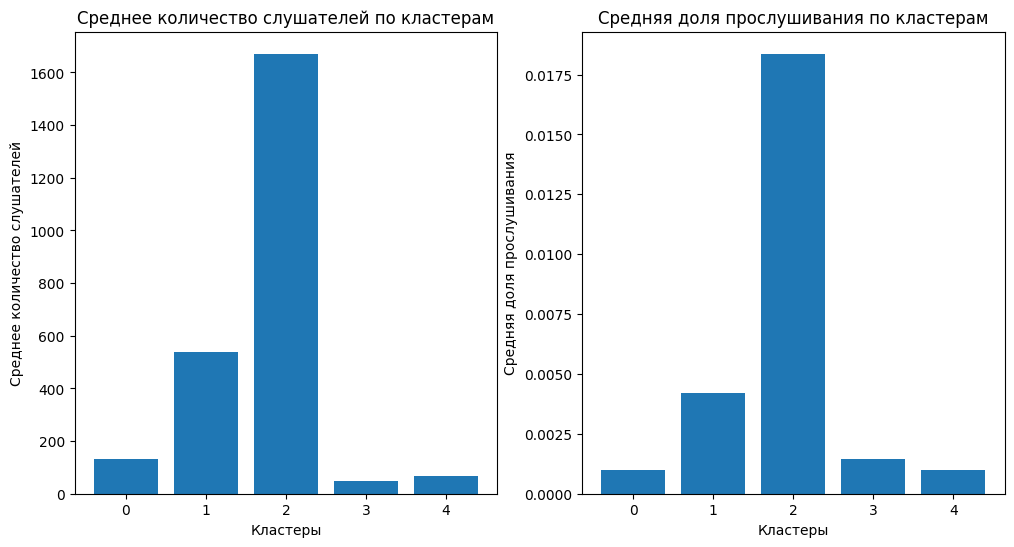

In [43]:
import matplotlib.pyplot as plt
clusters = k_means.labels_
# Подсчет числа слушателей и средней доли прослушивания для каждого исполнителя
num_of_listeners = (ratings > 0).sum(axis=1)
average_listening = ratings.mean(axis=1)

# Доля слушателей и средняя доля прослушивания для каждого кластера
cluster_summary = pd.DataFrame({
    'Average number of listeners': num_of_listeners,
    'Average listening': average_listening,
    'Cluster': clusters
}).groupby('Cluster').mean()

print(cluster_summary)



plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.bar(cluster_summary.index, cluster_summary['Average number of listeners'])
plt.title('Среднее количество слушателей по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Среднее количество слушателей')

plt.subplot(1, 2, 2)
plt.bar(cluster_summary.index, cluster_summary['Average listening'])
plt.title('Средняя доля прослушивания по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Средняя доля прослушивания')

plt.show()




The Beatles являются самыми популярными: у них ярко выделяется количество слушателей и доля прослушивания по сравнению со средним количеством прослушивания по кластерам

Задание 4 (0.5 балла) Улучшение кластеризации
Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи normalize.

In [44]:
from sklearn.preprocessing import normalize

normalized_ratings = normalize(ratings)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [45]:
k_means = KMeans(n_clusters = 5, random_state=0)
k_means = k_means.fit(normalized_ratings)
clusters = k_means.predict(normalized_ratings)
cluster_sizes = np.bincount(clusters)
cluster_sizes

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([210, 132, 227,  89, 342])

 размеры кластеров стали адекватными, теперь кластеризация может быть полезной

Задание 5 (1 балл) Центроиды
Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [46]:
normalized_ratings = pd.DataFrame(data=normalized_ratings, columns=ratings.columns)
normalized_ratings = normalized_ratings.set_index(ratings.index)
normalized_ratings.head()

from scipy.spatial.distance import cosine

centroids = k_means.cluster_centers_

for i in range(5):
    print(f"Кластер {i+1}:")
    cluster_artists = normalized_ratings.index[clusters == i]

    distances = []
    for artist in cluster_artists:
        artist_vector = normalized_ratings.loc[artist].values
        distance = cosine(artist_vector, centroids[i])
        distances.append((artist, distance))

    distances.sort(key=lambda x: x[1])
    top_10_artists = [artist for artist, _ in distances[:10]]
    for i in range(10):
      print(f"{i+1}) {top_10_artists[i]}")
    print()

Кластер 1:
1) sonic youth
2) the clash
3) the pixies
4) velvet underground
5) oy division
6) the ramones
7) the smiths
8) descendents
9) the misfits
10) fugazi

Кластер 2:
1) nas
2) a tribe called quest
3) jay-z
4) the roots featuring d'angelo
5) kanye west
6) mos def
7) gangstarr
8) lupe the gorilla
9) de la soul
10) little brother

Кластер 3:
1) sufjan stevens
2) radiohead
3) the arcade fire
4) the shins
5) broken social scene
6) belle and sebastian
7) deathcab for cutie
8) of montreal
9) animal collective
10) spoon

Кластер 4:
1) fall out boy
2) saosin
3) chiodos
4) taking back sunday
5) brand new
6) all time low
7) underoath
8) cartel
9) new found glory
10) mayday parade

Кластер 5:
1) coldplay
2) maroon5
3) john mayer
4) ‌linkin park
5) the killers
6) kelly clarkson
7) nickelback
8) red hot clili peppers
9) foo fighters
10) evanescense



1 - представляет собой альтернативный рок или панк-рок; кластер 2 - характеризуется хип-хопом; кластер 3 - содержит в себе инди-рок и альтернативную музыку; кластер 4 - ассоциируется с эмо и поп-панком; кластер 5 - представляет поп-рок.

Задание 6 (1 балл) Визуализация
Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики plt.scatter для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

<ipython-input-48-64b3a0d69136>:17: UserWarning: Glyph 65314 (\N{FULLWIDTH LATIN CAPITAL LETTER B}) missing from current font.
  plt.tight_layout()
<ipython-input-48-64b3a0d69136>:17: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from current font.
  plt.tight_layout()
<ipython-input-48-64b3a0d69136>:17: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  plt.tight_layout()
<ipython-input-48-64b3a0d69136>:17: UserWarning: Glyph 12465 (\N{KATAKANA LETTER KE}) missing from current font.
  plt.tight_layout()
<ipython-input-48-64b3a0d69136>:17: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  plt.tight_layout()
<ipython-input-48-64b3a0d69136>:17: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  plt.tight_layout()
<ipython-input-48-64b3a0d69136>:17: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  plt.tight_layout()
<ipython-input-48-64b3a0d69136>:17: UserWarning:

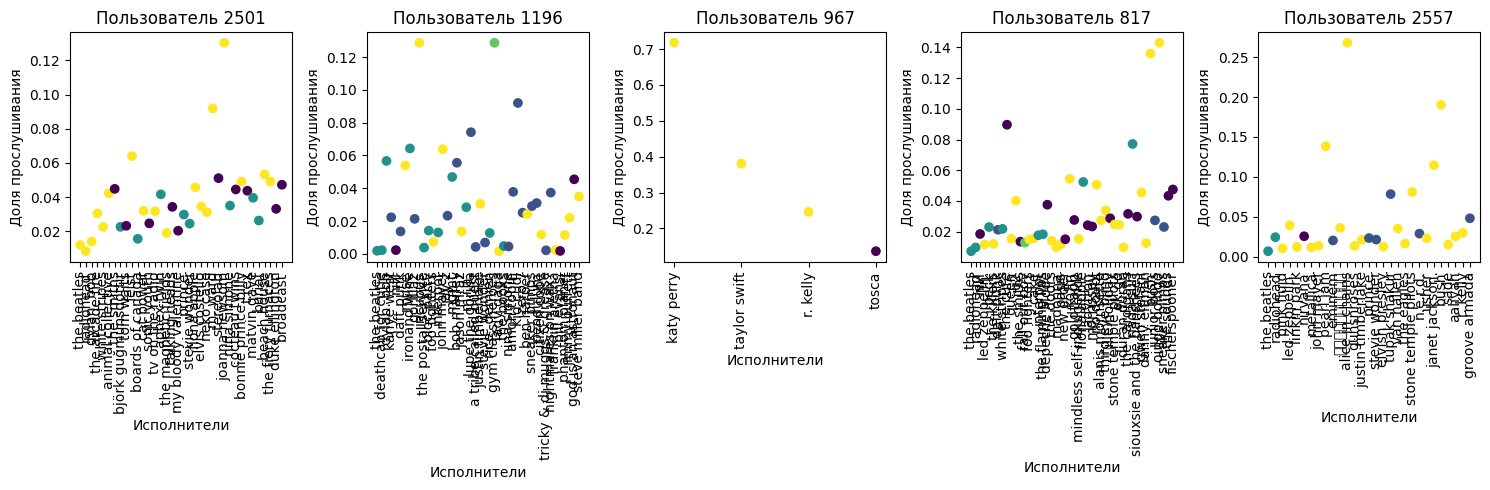

In [48]:
random_users = np.random.choice(normalized_ratings.columns, 5, replace=False)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, user in enumerate(random_users):
    user_ratings = normalized_ratings[user]
    nonzero_ratings = user_ratings[user_ratings > 0]
    nonzero_clusters = clusters[user_ratings > 0]

    axs[i].scatter(nonzero_ratings.index, nonzero_ratings.values, c=nonzero_clusters, cmap='viridis')
    axs[i].set_xticks(range(len(nonzero_ratings)))
    axs[i].set_xticklabels(nonzero_ratings.index, rotation=90)
    axs[i].set_ylabel('Доля прослушивания')
    axs[i].set_xlabel('Исполнители')
    axs[i].set_title(f'Пользователь {user}')

plt.tight_layout()
plt.show()

Графики позволяют увидеть, что у некоторых людей преобладает определенный жанр музыки, в то время как у других распределение по кластерам более равномерное, что может свидетельствовать об их меломанстве. Также можно заметить, что у многих пользователей есть определенный артист с наибольшей долей прослушивания, что указывает на их любимого исполнителя. Таким образом, эти графики подтверждают осмысленность разделения на кластеры и помогают выявить предпочтения слушателей в музыкальных жанрах и исполнителях.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените TSNE из библиотеки sklearn и визуализируйте полученные объекты, покрасив их в цвета их кластеров

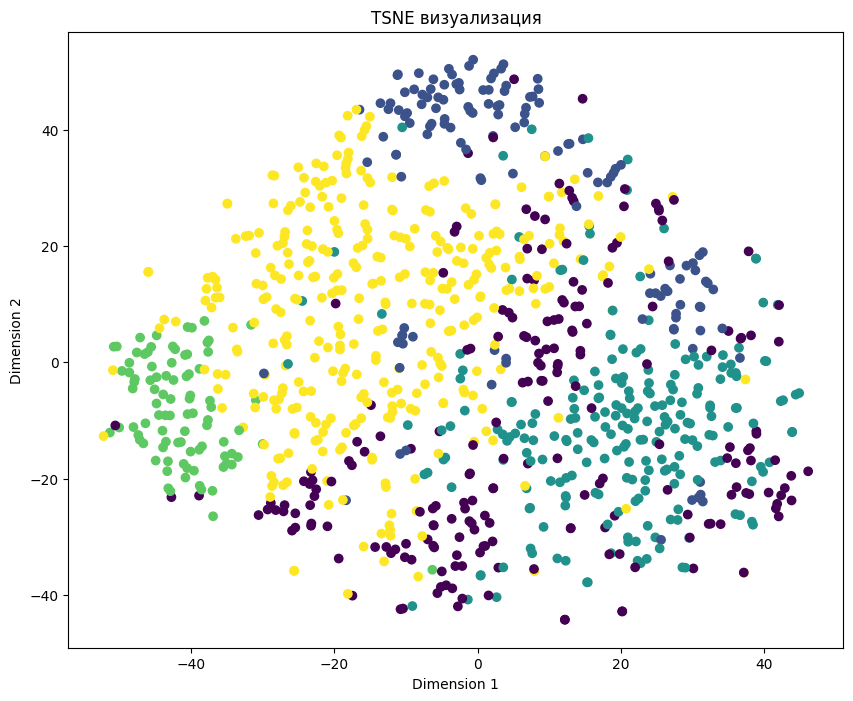

In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(normalized_ratings)

tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Cluster'], cmap='viridis', label=clusters)
plt.title('TSNE визуализация')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Задание 7 (1 балл) Подбор гиперпараметров
Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте random_state=42

In [50]:
from sklearn.metrics import silhouette_score

max_clusters = 100
silhouette_scores = []

for n_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(normalized_ratings)
    clusters = kmeans.predict(normalized_ratings)
    silhouette_avg = silhouette_score(normalized_ratings, clusters)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nОптимальное количество кластеров: {optimal_clusters}")


Оптимальное количество кластеров: 95


кажется, ничего другого я не ждала в жизни так долго, как оптимальное количество кластеров в этом задании...95...

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.



In [51]:
k_means = KMeans(n_clusters=95, random_state=42)
k_means.fit(normalized_ratings)
clusters = k_means.predict(normalized_ratings)
centroids = k_means.cluster_centers_

for i in range(95):
    print(f"Кластер {i+1}:")
    cluster_artists = normalized_ratings.index[clusters == i]

    distances = []
    for artist in cluster_artists:
        artist_vector = normalized_ratings.loc[artist].values
        distance = cosine(artist_vector, centroids[i])
        distances.append((artist, distance))

    distances.sort(key=lambda x: x[1])
    top_5_artists = [artist for artist, _ in distances[:5]]
    if len(top_5_artists) >= 5:
      print(*top_5_artists[0:5], sep=', ')
    else:
      print(*top_5_artists, sep=', ')
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Кластер 1:
circa survive, portugal. the man, cursive, citya and colour, the blood brothers

Кластер 2:
the brian jonestown massacre, spiritualized®, black rebel motorcycle club, the dandy warhols, the verve

Кластер 3:
squarepusher., autechre, amon tobin, boards of canada, aphex twin

Кластер 4:
talib kweli, the roots featuring d'angelo, mos def, little brother, common

Кластер 5:
mgmt, vampire weekend, tokyo police club, ratatat, kings of leon

Кластер 6:
my bloody valentine, deerhunter, animal collective, slowdive, beach house

Кластер 7:
destinys child, janet jackson., rihanna & jay-z, mariah carey, mary j. blige

Кластер 8:
the all-americian rejects, plain white t＇s, the red jumpsuit apparatus, hellogoodbye, secondhand serenade

Кластер 9:
u2, r.e.m., coldplay, bruce springsteen, bon jovi

Кластер 10:
the lawrence arms, jawbreaker, dillinger four, the glaslight anthem, alkaline trio

Кластер 11:
chiodos, scary kids scaring kids, from first to last, the used, from autumn to ashes

К

Кластер 17:
jay-z, lupe the gorilla, kanye west, nas, drake - ваши любимые рэперы )))

Кластер 55:
the ramones, the clash, the buzzcocks, the black lips, screeching weasel - еее панк-рокеры


Сделайте t-SNE визуализацию полученной кластеризации.

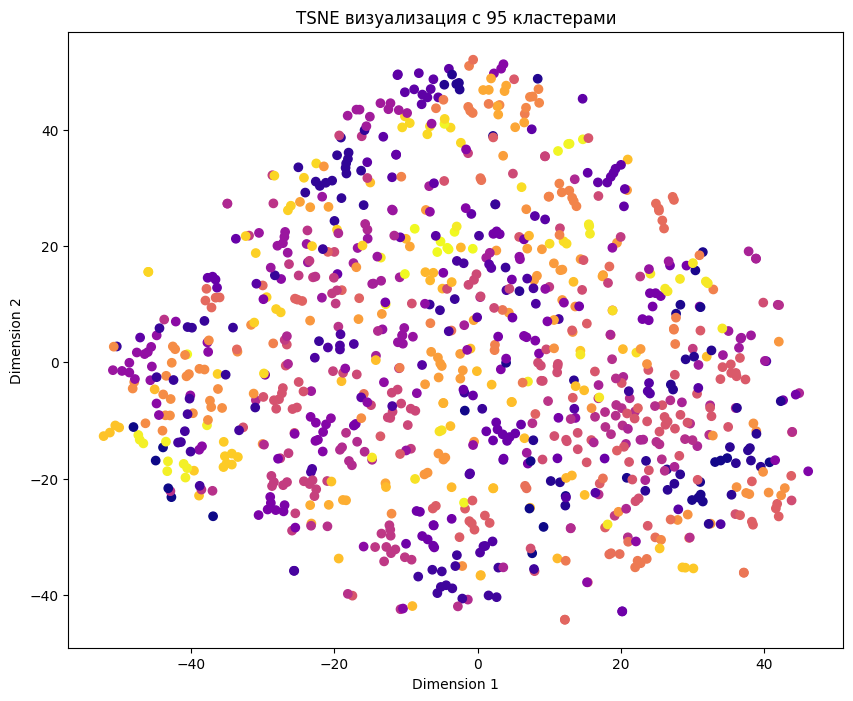

In [56]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(normalized_ratings)

tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Cluster'], cmap='plasma', label=clusters)
plt.title('TSNE визуализация с 95 кластерами')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (c = (labels == i)). Хорошо ли этот кластер отражается в визуализации?

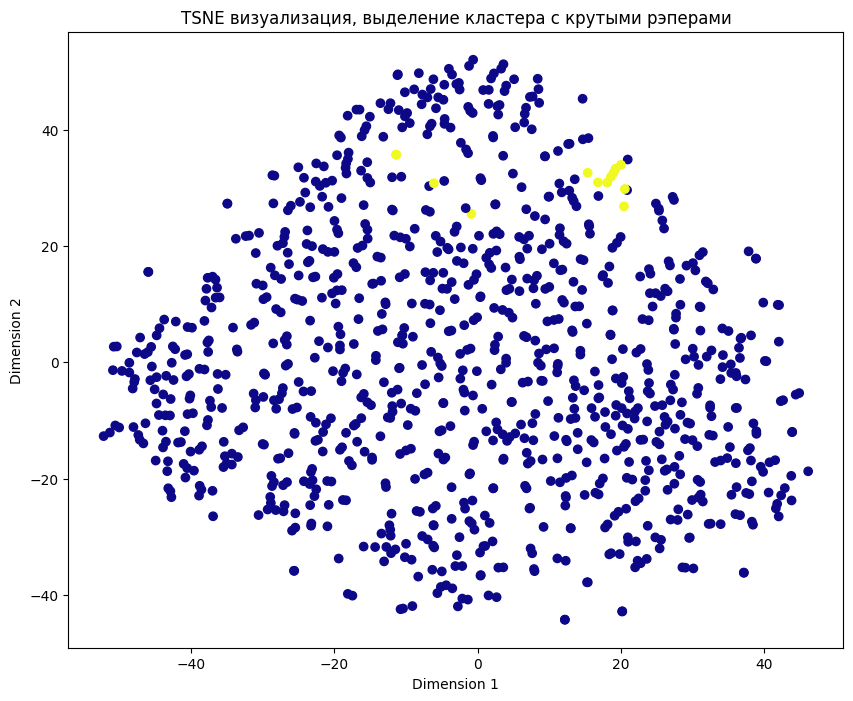

In [57]:
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c = (clusters == 17), cmap='plasma', label=clusters)
plt.title('TSNE визуализация, выделение кластера с крутыми рэперами')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Кластер с реперами круто выделяется в визуализации,наверное, потому что он достаточно сильно отличается от остальных (а как еще). В общем, мы круто сделали кластеризацию!
